In [1]:
import random
import time
from deap import base, creator, tools, algorithms
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import mlrose_hiive
from mlrose_hiive import DiscreteOpt
from mlrose_hiive import fitness
from mlrose_hiive.runners import RHCRunner, SARunner, GARunner, MIMICRunner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, ValidationCurveDisplay, LearningCurveDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from concurrent.futures import ThreadPoolExecutor

In [2]:
np.random.seed(24)

In [3]:
def n_queens_max(state):
    count = 0
    for i in range(len(state)-1):
        for j in range(i+1, len(state)):
            if (state[j] != state[i]) and (state[j] != state[i] + (j-i)) and (state[j] != state[i] - (j-i)):
                count +=1
    return count

customFitness = mlrose_hiive.CustomFitness(n_queens_max)

In [4]:
attacks, numQueens = 0, 64 
for i in range(numQueens+1):
    attacks += i
attacks

2080

In [5]:
iteration_list = [10000]
seed = 24
max_attempts = 100

In [6]:
problem = mlrose_hiive.DiscreteOpt(length = numQueens, fitness_fn = customFitness, 
                             maximize = True, max_val = numQueens)
problem.set_mimic_fast_mode(True)

In [11]:
%%time 
rhc = mlrose_hiive.RHCRunner(problem, experiment_name="rhcp", iteration_list=iteration_list,
                                       seed=seed, max_attempts=max_attempts, restart_list=[100])
rhc_run_stats, rhc_run_curves = rhc.run()

CPU times: total: 10min 14s
Wall time: 12min 12s


In [12]:
best_index_in_curve = rhc_run_curves.Fitness.idxmax()
best_decay = rhc_run_curves.iloc[best_index_in_curve].current_restart
best_curve = rhc_run_curves.loc[rhc_run_curves.current_restart == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

1.0

Text(0, 0.5, 'Fitness')

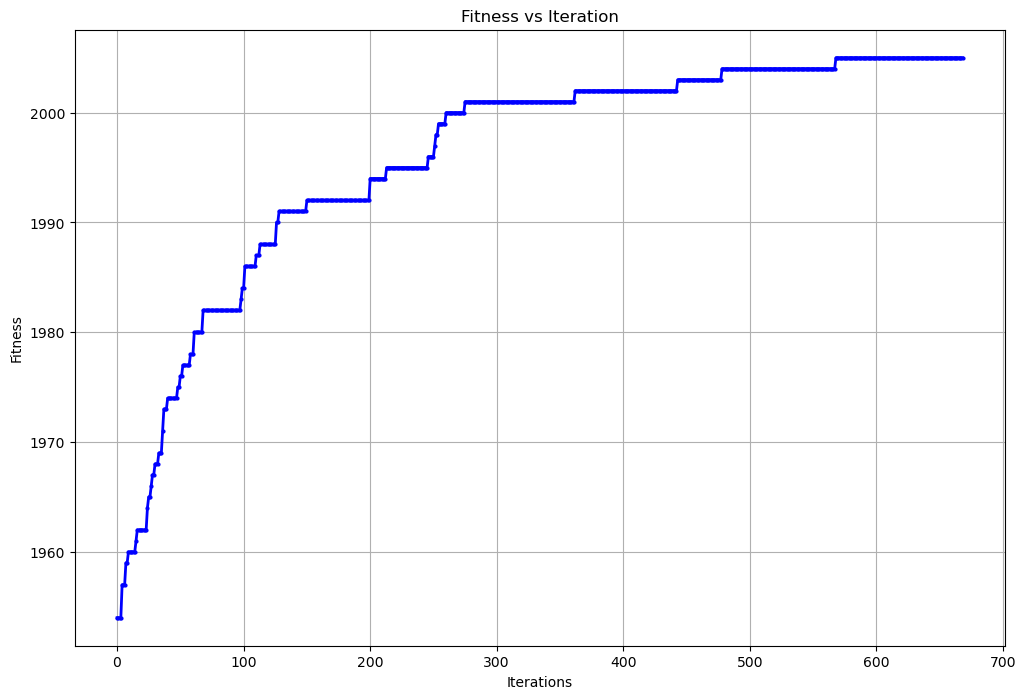

In [18]:
ax = best_curve.Fitness.plot(lw=2, colormap='winter', marker='o', markersize=2, 
                             figsize=(12,8), grid=1,
                             title='Fitness vs Iteration')
ax.set_xlabel("Iterations")
ax.set_ylabel("Fitness")

In [17]:
last_iters = rhc_run_stats[rhc_run_stats.Iteration != 0].reset_index()
print(last_iters.Fitness.mean(), last_iters.Fitness.max())
print(last_iters.Time.max())

1999.2673267326732 2005.0
560.7274735999963


In [18]:
rhc_run_curves

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.022691,1925.0,0.0,100,10000,0
1,1,0.044501,1929.0,2.0,100,10000,0
2,2,0.047862,1931.0,4.0,100,10000,0
3,3,0.049580,1931.0,5.0,100,10000,0
4,4,0.052925,1932.0,7.0,100,10000,0
...,...,...,...,...,...,...,...
54252,677,1.268885,2003.0,58209.0,100,10000,100
54253,678,1.270573,2003.0,58210.0,100,10000,100
54254,679,1.272263,2003.0,58211.0,100,10000,100
54255,680,1.273954,2003.0,58212.0,100,10000,100


In [7]:
%%time
sim_annealing = mlrose_hiive.SARunner(problem, experiment_name="sim_ann", 
                           iteration_list=iteration_list,
                           temperature_list=[1, 5, 10, 100, 250, 500, 750, 1000, 5000, 10000],
                           decay_list=[mlrose_hiive.ExpDecay,
                                       mlrose_hiive.GeomDecay],
                           seed=seed, max_attempts=max_attempts)
sa_run_stats, sa_run_curves = sim_annealing.run()   

CPU times: total: 2min 16s
Wall time: 2min 21s


In [8]:
final_iterations = sa_run_stats[sa_run_stats.Iteration != 0].reset_index()

print(final_iterations.Fitness.mean(), final_iterations.Fitness.max())
print(final_iterations.Time.mean())

2009.3 2011.0
7.028364385000896


In [10]:
best_idx = sa_run_curves.Fitness.idxmax()
best_decay = sa_run_curves.iloc[best_idx].Temperature
best_curve = sa_run_curves.loc[sa_run_curves.Temperature == best_decay, :]
best_curve.reset_index(inplace=True)
best_decay

GeomDecay(init_temp=100, decay=0.99, min_temp=0.001)

Text(0, 0.5, 'Fitness')

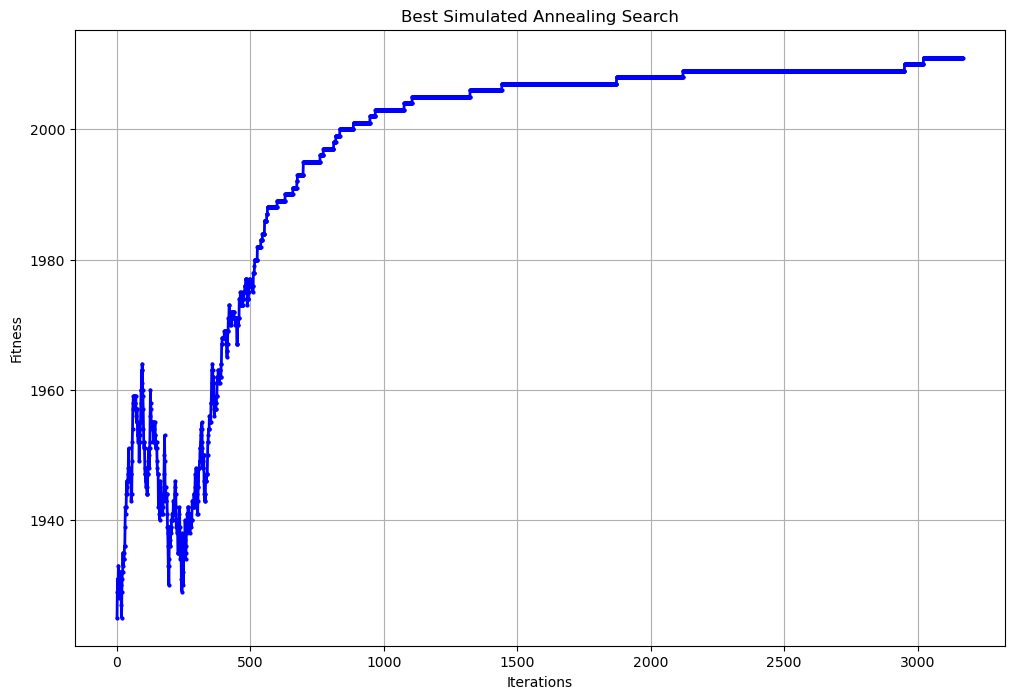

In [11]:
ax = best_curve.Fitness.plot(lw=2, colormap='winter', marker='o', markersize=2, 
                             figsize=(12,8), grid=1,
                             title='Best Simulated Annealing Search')
ax.set_xlabel("Iterations")
ax.set_ylabel("Fitness")

In [12]:
%%time
gen_alg = mlrose_hiive.GARunner(problem=problem,
                          experiment_name="gen_alg",
                          seed=seed,
                          iteration_list=iteration_list,
                          max_attempts=max_attempts,
                          population_sizes=[50, 200, 500, 1000],
                          mutation_rates=[0.1, 0.25, 0.5, 0.75])
ga_run_stats, ga_run_curves = gen_alg.run()  

CPU times: total: 57min 55s
Wall time: 1h 3min 16s


In [14]:
ga_run_stats

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
0,0,1925.0,50,0.094269,"[34, 3, 0, 23, 17, 17, 1, 36, 59, 15, 4, 47, 3...",50,0.10,10000
1,10000,2000.0,12110,19.689164,"[53, 7, 33, 54, 0, 9, 16, 63, 26, 42, 39, 31, ...",50,0.10,10000
2,0,1925.0,50,0.086912,"[34, 3, 0, 23, 17, 17, 1, 36, 59, 15, 4, 47, 3...",50,0.25,10000
3,10000,2004.0,12829,21.247518,"[33, 27, 60, 46, 18, 51, 18, 22, 19, 34, 55, 3...",50,0.25,10000
4,0,1925.0,50,0.077521,"[34, 3, 0, 23, 17, 17, 1, 36, 59, 15, 4, 47, 3...",50,0.50,10000
5,10000,2002.0,25009,42.215494,"[37, 24, 57, 39, 63, 2, 11, 21, 10, 55, 13, 18...",50,0.50,10000
6,0,1925.0,50,0.084460,"[34, 3, 0, 23, 17, 17, 1, 36, 59, 15, 4, 47, 3...",50,0.75,10000
7,10000,2001.0,25419,40.934504,"[53, 20, 42, 48, 34, 51, 27, 38, 1, 38, 6, 35,...",50,0.75,10000
8,0,1925.0,200,0.304139,"[34, 3, 0, 23, 17, 17, 1, 36, 59, 15, 4, 47, 3...",200,0.10,10000
9,10000,2009.0,57917,92.696643,"[0, 53, 22, 7, 35, 54, 44, 60, 38, 52, 59, 23,...",200,0.10,10000


Text(0, 0.5, 'Time in Seconds')

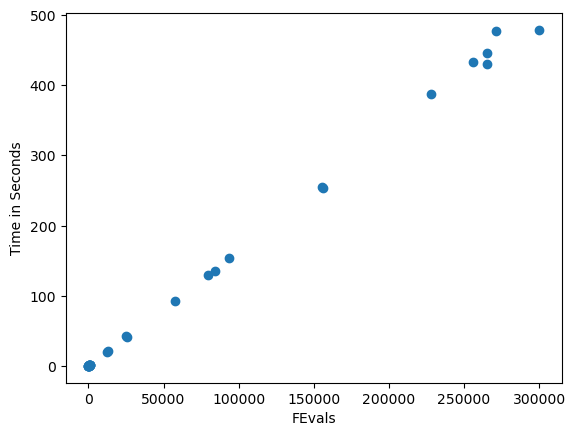

In [16]:
plt.scatter(x=ga_run_stats['FEvals'], y=ga_run_stats['Time'])
plt.xlabel("FEvals")
plt.ylabel("Time in Seconds")

In [13]:
final_iterations = ga_run_stats[ga_run_stats.Iteration != 0].reset_index()


print(final_iterations.Fitness.max(), final_iterations.Fitness.mean(), final_iterations.Time.mean())
print(final_iterations.groupby("Mutation Rate").Fitness.mean())
print(final_iterations.groupby("Population Size").Fitness.mean())
print(final_iterations.groupby("Population Size").Time.mean())

2013.0 2000.6875 237.2436200187367
Mutation Rate
0.10    2000.00
0.25    2001.25
0.50    2001.50
0.75    2000.00
Name: Fitness, dtype: float64
Population Size
50      2001.75
200     2009.25
500     2010.75
1000    1981.00
Name: Fitness, dtype: float64
Population Size
50       31.021670
200     128.075806
500     410.968294
1000    378.908709
Name: Time, dtype: float64


In [7]:
%%time
mimic = mlrose_hiive.MIMICRunner(problem=problem, experiment_name="mimic", seed=seed,
                  iteration_list=iteration_list, max_attempts=max_attempts,
                  population_sizes=[50, 200, 500], keep_percent_list=[0.25, 0.5, 0.75], use_fast_mimic=True)

# the two data frames will contain the results
mmc_run_stats, mmc_run_curves = mimic.run()

CPU times: total: 2h 55min 48s
Wall time: 2h 59min 14s


In [8]:
final_iterations = mmc_run_stats[mmc_run_stats.Iteration != 0].reset_index()
print("Max and mean")
print(final_iterations.Fitness.max(), final_iterations.Fitness.mean(), final_iterations.Time.mean())
print(final_iterations.groupby("Keep Percent").Fitness.mean())
print(final_iterations.groupby("Population Size").Fitness.mean())
print(final_iterations.groupby("Population Size").Time.mean())

Max and mean
1988.0 1973.888888888889 1194.9173691777687
Keep Percent
0.25    1973.666667
0.50    1974.333333
0.75    1973.666667
Name: Fitness, dtype: float64
Population Size
50     1961.000000
200    1975.666667
500    1985.000000
Name: Fitness, dtype: float64
Population Size
50      382.317897
200     870.489364
500    2331.944846
Name: Time, dtype: float64


In [18]:
plt.scatter(x=mmc_run_stats['FEvals'], y=mmc_run_stats['Time'])
plt.xlabel("FEvals")
plt.ylabel("Time in Seconds")

NameError: name 'mmc_run_stats' is not defined